# Analysis of Scenario-Level Action Rarity Scores

**Objective:** To load and analyze the aggregated scenario scores based on
action rarity. This notebook helps us understand the distribution of scenarios
with rare behaviors and visually inspect the top-ranked scenario to validate
our aggregation logic.

In [ ]:
# ## 1. Setup and Configuration
import os
import sys
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid")

print("Setup Complete.")

Configuration loaded successfully.
Setup Complete.


Loaded scores for 106487 scenarios.

--- Overall Score Statistics (P95 of Timestep Action Rarity) ---
count    106487.000000
mean          0.011962
std           0.008532
min           0.010001
25%           0.010017
50%           0.010102
75%           0.011168
max           0.990195
Name: score, dtype: float64


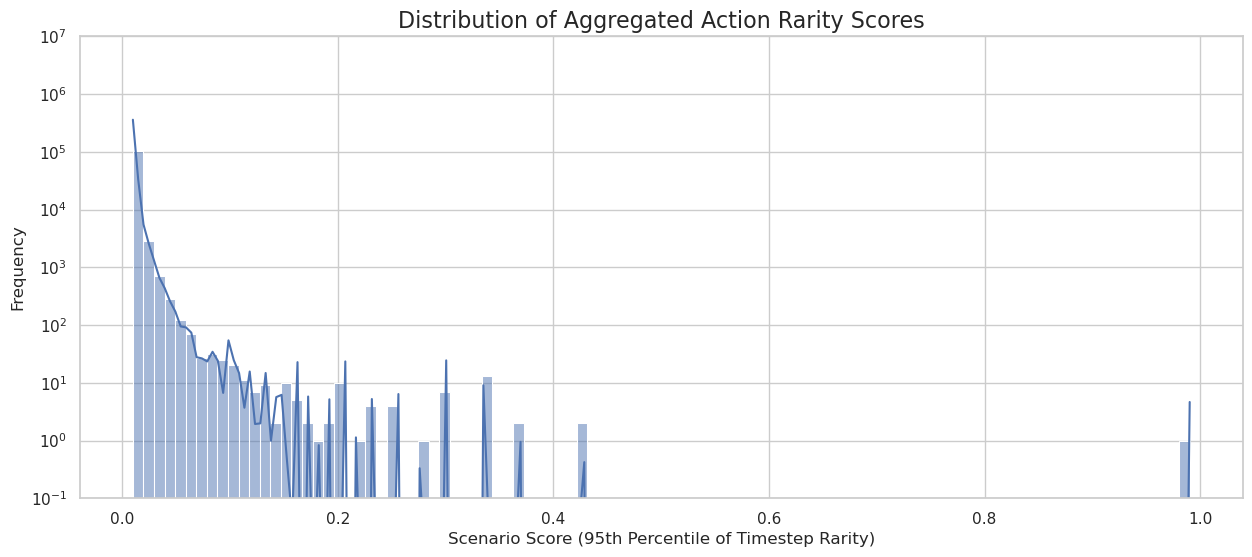


--- Top 10 Scenarios with the Rarest Peak Actions ---


,scenario_id,score,normalized_score
99790,4a28daf3a8e82448,0.990195,1.000000
93351,f57218dabcf50ba3,0.426582,0.430806
105406,e28b76cfd0a00d11,0.426582,0.430806
71509,bf7ee98433e7b4a8,0.367770,0.371412
85589,e228ec108df27a2a,0.367770,0.371412
91260,f03db601e83ae39f,0.336732,0.340066
71402,bf25d74400aaead2,0.336732,0.340066
79292,d2b8269e591f7279,0.336732,0.340066
87864,e7c8c6c330e5f786,0.336732,0.340066
24208,4b728e1bf4da66ef,0.336732,0.340066


In [8]:
# ## 2. Load Scenario Scores and Analyze Distribution
# 
# Load the final `.pt` file containing the dictionary of `{scenario_id: score}`.

# --- Load the Data ---
scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'scenario_level')
action_rarity_scores_path = os.path.join(scores_dir, 'action_rarity_scenario_scores.pt')

if not os.path.exists(action_rarity_scores_path):
    raise FileNotFoundError("Action-rarity scenario scores not found. "
                            "Please run `score_criticality_action_scenario.py` first.")

scenario_scores_dict = torch.load(action_rarity_scores_path)

# Convert to a Pandas DataFrame for easy analysis and sorting
scores_df = pd.DataFrame(list(scenario_scores_dict.items()), columns=['scenario_id', 'score'])
# Normalize the score to a 0-1 range for easier interpretation
if scores_df['score'].max() > 0:
    scores_df['normalized_score'] = scores_df['score'] / scores_df['score'].max()
else:
    scores_df['normalized_score'] = 0.0

print(f"Loaded scores for {len(scores_df)} scenarios.")

# --- Analyze and Plot Distribution ---
print("\n--- Overall Score Statistics (P95 of Timestep Action Rarity) ---")
print(scores_df['score'].describe())

plt.figure(figsize=(15, 6))
sns.histplot(scores_df['score'], bins=100, kde=True)
plt.title('Distribution of Aggregated Action Rarity Scores', fontsize=16)
plt.xlabel('Scenario Score (95th Percentile of Timestep Rarity)')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale to see the long tail
plt.ylim(0.1, 10e6) # Avoid log(0) issues
plt.show()

# --- Identify Top "Rarest" Scenarios ---
top_10_rare_scenarios = scores_df.sort_values(by='score', ascending=False).head(10)
print("\n--- Top 10 Scenarios with the Rarest Peak Actions ---")
display(top_10_rare_scenarios)

--- Deep Dive Analysis for Top Scenario: e28b76cfd0a00d11 ---
Overall Scenario Score (P95 Rarity): 0.4266


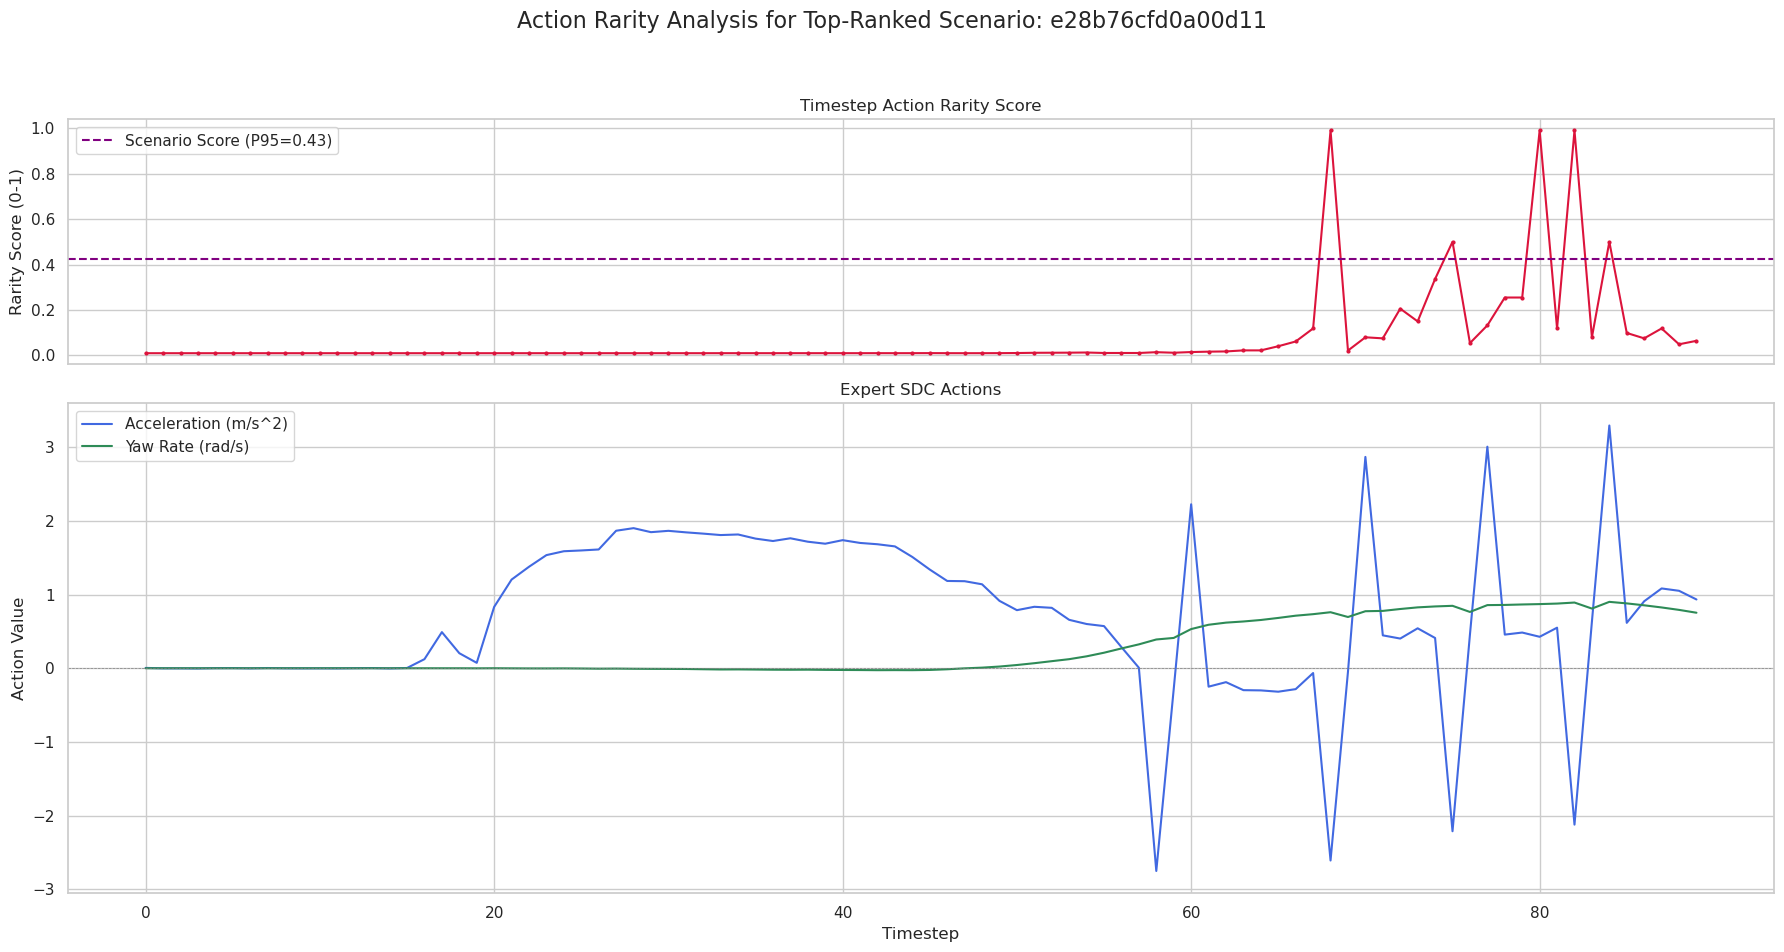

In [ ]:
# ## 3. Deep Dive into the Top-Ranked Scenario
# 
# Let's pick the #1 scenario with the rarest peak action and visualize its underlying timestep-level scores to understand *why* it received such a high score.

# Select the top scenario
top_scenario_id = top_10_rare_scenarios.iloc[2]['scenario_id']
top_scenario_score = top_10_rare_scenarios.iloc[0]['score']

print(f"--- Deep Dive Analysis for Top Scenario: {top_scenario_id} ---")
print(f"Overall Scenario Score (P95 Rarity): {top_scenario_score:.4f}")

# --- Load its timestep-level score and action data ---
timestep_scores_path = os.path.join(
    config['data']['criticality_scores_dir'], 
    'timestep_level', 
    'action_rarity', 
    'training', # Assuming it's from the training set
    f"{top_scenario_id}.npz"
)
featurized_path = os.path.join(config['data']['featurized_dir'], 'training', f"{top_scenario_id}.pt")

# Check validation set if not in training
if not os.path.exists(timestep_scores_path):
    timestep_scores_path = timestep_scores_path.replace('/training/', '/validation/')
    featurized_path = featurized_path.replace('/training/', '/validation/')
    if not os.path.exists(timestep_scores_path):
        raise FileNotFoundError(f"Could not find timestep-level action rarity scores for {top_scenario_id}")

scores_data = np.load(timestep_scores_path)
rarity_scores = scores_data['action_rarity']
actions = torch.load(featurized_path)['actions'].numpy()

# --- Plot the underlying score vs. actions ---
fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True, 
                         gridspec_kw={'height_ratios': [1, 2]})
fig.suptitle(f'Action Rarity Analysis for Top-Ranked Scenario: {top_scenario_id}', fontsize=16)

timesteps = np.arange(len(rarity_scores))
# Plot 1: Rarity Score
axes[0].plot(timesteps, rarity_scores, marker='.', linestyle='-', markersize=4, color='crimson')
axes[0].set_title('Timestep Action Rarity Score')
axes[0].set_ylabel('Rarity Score (0-1)')
axes[0].axhline(y=top_scenario_score, color='purple', linestyle='--', label=f'Scenario Score (P95={top_scenario_score:.2f})')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Actual Expert Actions
axes[1].plot(timesteps, actions[:, 0], label='Acceleration (m/s^2)', color='royalblue')
axes[1].plot(timesteps, actions[:, 1], label='Yaw Rate (rad/s)', color='seagreen')
axes[1].set_title('Expert SDC Actions')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Action Value')
axes[1].legend()
axes[1].grid(True)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# ## 4. Generate Video for the Top-Ranked Scenario
# 
# Let's watch the video. Does this scenario contain a clear, high-intensity maneuver that justifies its high score?

raw_data_path = os.path.join(
    config['data']['processed_npz_dir'], 
    'training', # Assuming it's from the training set
    f"{top_scenario_id}.npz"
)
# Check validation set if not in training
if not os.path.exists(raw_data_path):
    raw_data_path = raw_data_path.replace('/training/', '/validation/')

print(f"\nGenerating scenario animation for: {top_scenario_id}...")
try:
    video_output_dir = 'outputs/action_rarity_scenario_validation_videos'
    visualize_scenario(raw_data_path, output_dir=video_output_dir)
    print(f"\n✅ Animation saved to '{video_output_dir}/{top_scenario_id}.mp4'")
except Exception as e:
    print(f"\n❌ An error occurred during animation: {e}")


Generating scenario animation for: e28b76cfd0a00d11...
Loading scenario from: /mnt/d/waymo_datasets/waymo_longtail_rl_data/processed_npz/validation/e28b76cfd0a00d11.npz
Creating animation for timestep 0 to 90...
Animation saved to: outputs/action_rarity_scenario_validation_videos/e28b76cfd0a00d11.mp4

✅ Animation saved to 'outputs/action_rarity_scenario_validation_videos/e28b76cfd0a00d11.mp4'
